<a href="https://colab.research.google.com/github/valtanenamanda/FAIML_exercises/blob/main/pytorch_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch # to load pytorch library
import torch.nn as nn # to load pytorch library
import torch.nn.functional as F # to load pytorch function
import torch.utils.data # to load data processor
from torch.autograd import Variable # pytorch data type
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Columns: 785 entries, 6 to 0.590
dtypes: int64(785)
memory usage: 119.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Columns: 785 entries, 7 to 0.667
dtypes: int64(785)
memory usage: 59.9 MB


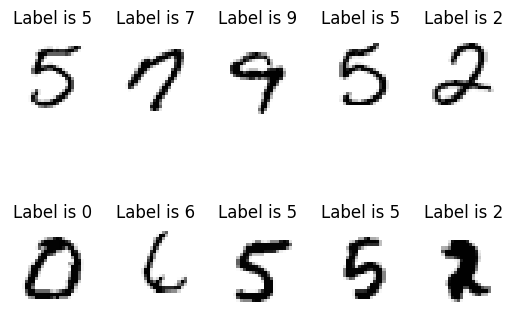

In [ ]:
train = pd.read_csv('/content/sample_data/mnist_train_small.csv')
test = pd.read_csv('/content/sample_data/mnist_test.csv')

train.info()
test.info()

# split image and label
train_label = train.iloc[:, 0].values
train_img = train.iloc[:, 1:]
test_label = test.iloc[:, 0].values
test_img = test.iloc[:, 1:]
# check the dataset of one example
count=1
for a in range (10):
    imarray = train_img.iloc[a, :].values.reshape(28,28)
    plt.subplot(2,5,count)
    plt.subplots_adjust(hspace=0.1)
    count += 1
    plt.axis('off')
    plt.title("Label is " + str(train_label[a]))
    plt.imshow(imarray, cmap='Greys', interpolation='None')

In [ ]:
# reshape to be [samples][pixels][width][height]
train_img = train_img.values.reshape(-1,1,28,28)
test_img = test_img.values.reshape(-1,1,28,28)
train_img = train_img / 255.0
test_img = test_img / 255.0
# normalize inputs from 0-255 to 0-1
print(train_img.shape)
print(train_label.shape)
print(test_img.shape)
print(test_label.shape)

BATCH_SIZE = 1000

# create feature and targets tensor for training set.
torch_X_train = torch.from_numpy(train_img).float()
torch_y_train = torch.from_numpy(train_label)
# create feature and targets tensor for testing set.
torch_X_test = torch.from_numpy(test_img).float()
torch_y_test = torch.from_numpy(test_label)
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False, num_workers=4)

(19999, 1, 28, 28)
(19999,)
(9999, 1, 28, 28)
(9999,)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Defining the network (LeNet-5)
class LeNet5(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.act1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.act2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=400, out_features=120)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = self.conv1(x)
        x = self.act1(x)
        x = self.maxpool1(x)
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = self.conv2(x)
        x = self.act2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 400)
        #Fully Connected Layer/Activation
        x = self.fc1(x)
        x = self.act3(x)
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        x = self.act4(x)

        return self.fc3(x)

criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    criterion = criterion.cuda()


In [ ]:
def train(model, epoch, optimizer):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable.
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch.
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = criterion(output, target)
        #dloss/dx for every Variable
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        epoch_loss += loss.item()
    #Print out the loss periodically.
    avg_loss = epoch_loss / len(train_loader)
    print("===> Epoch {} Complete: Training loss: {:.4f}".format(epoch, avg_loss))
    return avg_loss

In [ ]:
def train_accuracy(model, epoch):
    model.eval()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        with torch.no_grad():
            output = model(data)
        _, predicted = torch.max(output.data, 1) # get the index of the max log-probability
        correct += (predicted == target).sum().item()
    avg_accuracy = correct / len(train_loader.dataset)
    print("===> Epoch {} Complete: Training accuracy: {:.4f}%".format(epoch, 100. * avg_accuracy))
    return avg_accuracy

In [ ]:
def test(model, epoch):
    model.eval()
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        data, target = Variable(data), Variable(target)
        with torch.no_grad():
            output = model(data)
        _, predicted = torch.max(output.data, 1) # get the index of the max log-probability
        correct += (predicted == target).sum().item()
    avg_accuracy = correct / len(test_loader.dataset)
    print("===> Epoch {} Complete: Testing accuracy: {:.4f}%".format(epoch, 100. * avg_accuracy))
    return avg_accuracy

In [ ]:
def checkpoint(model, epoch):
    model_out_path = "Training_epoch_{}.pth".format(epoch)
    torch.save(model.state_dict(), model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
model = LeNet5()

if torch.cuda.is_available():
    model.cuda() # set model to use GPU if available, defaults to CPU


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
train_losses = []
train_correct = []
test_correct = []
for epoch in range(1, 51, 1):
    # Trainining loss
    train_loss = train(model, epoch, optimizer)
    train_losses.append(train_loss)

    # Training accuracy
    training_accuracy = train_accuracy(model, epoch)
    train_correct.append(training_accuracy)

    # Testing accuracy
    test_accuracy = test(model, epoch)
    test_correct.append(test_accuracy)
    if epoch % 10 == 0:
        # Model checkpointing
        checkpoint(model, epoch)

===> Epoch 1 Complete: Training loss: 2.3071
===> Epoch 1 Complete: Training accuracy: 10.1105%
===> Epoch 1 Complete: Testing accuracy: 10.0810%
===> Epoch 2 Complete: Training loss: 2.3060
===> Epoch 2 Complete: Training accuracy: 10.1155%
===> Epoch 2 Complete: Testing accuracy: 10.0910%
===> Epoch 3 Complete: Training loss: 2.3050
===> Epoch 3 Complete: Training accuracy: 10.1155%
===> Epoch 3 Complete: Testing accuracy: 10.0910%
===> Epoch 4 Complete: Training loss: 2.3040
===> Epoch 4 Complete: Training accuracy: 10.1155%
===> Epoch 4 Complete: Testing accuracy: 10.0910%
===> Epoch 5 Complete: Training loss: 2.3032
===> Epoch 5 Complete: Training accuracy: 10.1155%
===> Epoch 5 Complete: Testing accuracy: 10.0910%
===> Epoch 6 Complete: Training loss: 2.3023
===> Epoch 6 Complete: Training accuracy: 10.1155%
===> Epoch 6 Complete: Testing accuracy: 10.0910%
===> Epoch 7 Complete: Training loss: 2.3015
===> Epoch 7 Complete: Training accuracy: 10.1155%
===> Epoch 7 Complete: Testi

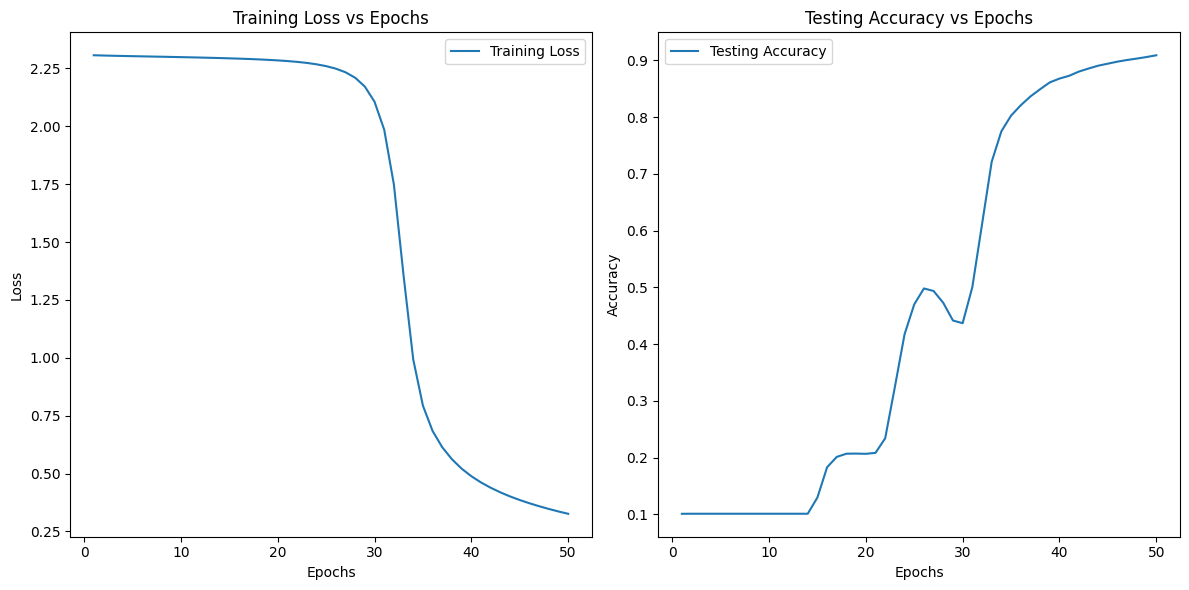

In [ ]:
epochs = range(1, 51)

plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.legend()

# Plot testing accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_correct, label="Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Testing Accuracy vs Epochs")
plt.legend()

plt.tight_layout()
plt.show()

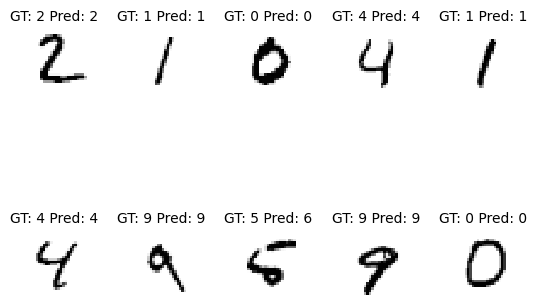

In [ ]:
model_name = 'Training_epoch_50.pth'
model.load_state_dict(torch.load(model_name, map_location=lambda storage, loc: storage)) # load the trained model
count=1
model.eval()
for a in range (10):
    imarray = test_img[a].reshape(1,1,28,28)
    data = torch.from_numpy(imarray).float()
    if torch.cuda.is_available():
        data = data.cuda()

    # Input the image to the loaded model
    # Get the predicted class labels using argmax or max on the model output

    with torch.no_grad():
        output = model(data)
    _, predicted = torch.max(output.data, 1)

    plt.subplot(2,5,count)
    plt.subplots_adjust(hspace=0.2, wspace = 0.6)
    count += 1
    plt.axis('off')
    plt.title('GT: ' + str(test_label[a]) + ' Pred: ' + str(predicted.item()), fontsize=10)
    plt.imshow(imarray[0,0,:,:], cmap='Greys', interpolation='None')
plt.show()

In [ ]:
model2 = LeNet5() # initialize a new model
if torch.cuda.is_available():
    model2.cuda() # Move the model to GPU if available
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.5)

In [ ]:
new_train_losses = []
new_train_correct = []
new_test_correct = []
for epoch in range(1, 51, 1):
    # Trainining loss
    train_loss = train(model2, epoch, optimizer2)
    train_losses.append(train_loss)

    # Training accuracy
    training_accuracy = train_accuracy(model2, epoch)
    train_correct.append(training_accuracy)

    # Testing accuracy
    test_accuracy = test(model2, epoch)
    test_correct.append(test_accuracy)


===> Epoch 1 Complete: Training loss: 2.2709
===> Epoch 1 Complete: Training accuracy: 28.0164%
===> Epoch 1 Complete: Testing accuracy: 27.5228%
===> Epoch 2 Complete: Training loss: 2.1408
===> Epoch 2 Complete: Training accuracy: 37.8419%
===> Epoch 2 Complete: Testing accuracy: 37.9338%
===> Epoch 3 Complete: Training loss: 2.1651
===> Epoch 3 Complete: Training accuracy: 28.5264%
===> Epoch 3 Complete: Testing accuracy: 28.5929%
===> Epoch 4 Complete: Training loss: 2.0200
===> Epoch 4 Complete: Training accuracy: 24.5612%
===> Epoch 4 Complete: Testing accuracy: 24.5725%
===> Epoch 5 Complete: Training loss: 1.9182
===> Epoch 5 Complete: Training accuracy: 47.0274%
===> Epoch 5 Complete: Testing accuracy: 47.8548%
===> Epoch 6 Complete: Training loss: 1.6063
===> Epoch 6 Complete: Training accuracy: 64.2232%
===> Epoch 6 Complete: Testing accuracy: 64.0964%
===> Epoch 7 Complete: Training loss: 0.7067
===> Epoch 7 Complete: Training accuracy: 88.4644%
===> Epoch 7 Complete: Testi